In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/DS_340/side_project/kaggle_trash_dataset

In [ ]:
def get_accuracy_and_loss(model, loader, criterion):
  model.eval()
  my_loss = 0
  with torch.no_grad():
    correct = 0
    for data, target in loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1)
      correct += pred.eq(target).sum().item()
      my_loss += criterion(output, target).item()
  return correct/len(loader.dataset), my_loss/len(loader.dataset)

In [ ]:
# TODO set device to cuda
if torch.cuda.is_available():
  print("GPU detected")
  device = torch.device("cuda")
else:
  print("No GPU detected")
  device = torch.device("cpu")

GPU detected


In [ ]:
recycling = {
    'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans',
    'cardboard_boxes', 'cardboard_packaging',
    'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars',
    'magazines', 'newspaper', 'office_paper',
    'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers',
    'plastic_soda_bottles', 'plastic_water_bottles',
    'steel_food_cans'
}

trash = {
    'clothing', 'coffee_grounds', 'disposable_plastic_cutlery',
    'eggshells', 'food_waste',
    'plastic_shopping_bags', 'plastic_straws', 'plastic_trash_bags',
    'styrofoam_cups', 'styrofoam_food_containers',
    'tea_bags', 'shoes', 'paper_cups'
}

class BinaryTrashRecycleDataset(torch.utils.data.Dataset):
    def __init__(self, imagefolder_dataset, label_map):
        self.dataset = imagefolder_dataset
        self.label_map = label_map

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, original_label = self.dataset[idx]

        # Get the folder name
        class_name = self.dataset.classes[original_label]

        # Map to 0 or 1
        mapped_label = self.label_map[class_name]

        return img, torch.tensor(mapped_label, dtype=torch.long)


label_map = {}
for cls in recycling:
    label_map[cls] = 1
for cls in trash:
    label_map[cls] = 0



In [ ]:
recycling = {''}

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-15,15)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transition_dataset = datasets.ImageFolder("kaggle_trash_dataset/images/images", transform=transform)

dataset = BinaryTrashRecycleDataset(transition_dataset, label_map)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


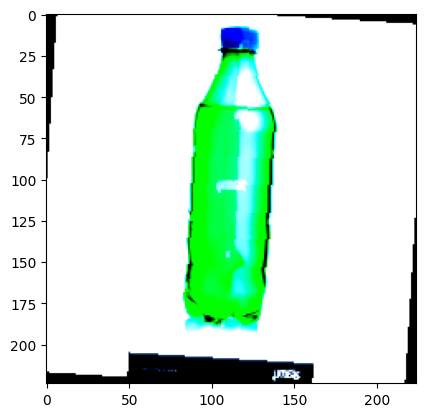

In [ ]:
batch, label = next(iter(train_loader))

img = batch[0]

#Rearranges dimensions
img = img.permute(1,2,0)

plt.imshow(img)



In [ ]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)      # (224,224) to (224,224)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)     # (224,224) to (224,224)
        self.pool1 = nn.MaxPool2d(kernel_size=2)                     # (224,224) to (112,112)
        self.dropout1 = nn.Dropout(0.25)                             # 25% chance of drop
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)  # (112,112) to (112,112)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding = 1) # (112,112) to (112,112)
        self.pool2 = nn.MaxPool2d(kernel_size=2)                     # (112,112) to (56,56)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax for cross-entropy loss
        return x

In [ ]:
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
patience = 3
epochs_without_improve = 0
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(15):  # More training time could mean more accuracy so play around with the range and see how accurate you can get it before overfitting
    model.train()
    train_loss = 0
    correct = 0
    total_count = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total_count += data.size(0)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} done.")
    train_accuracy = correct / total_count
    train_loss = train_loss / total_count
    print(f"Train accuracy: {train_accuracy}")
    train_accuracies.append(train_accuracy)
    print(f"Train loss: {train_loss}")
    train_losses.append(train_loss)
    val_accuracy, val_loss = get_accuracy_and_loss(model, val_loader, criterion)
    print(f"Val accuracy: {val_accuracy}")
    val_accuracies.append(val_accuracy)
    print(f"Val loss: {val_loss}")
    val_losses.append(val_loss)
    # Check for improvement
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), 'best_model.pth')
      epochs_without_improve = 0
    else:
      epochs_without_improve += 1
      if epochs_without_improve >= patience:
        break

Epoch 0 done.
Train accuracy: 0.5763333333333334
Train loss: 0.024242701654632885
Val accuracy: 0.591
Val loss: 0.021099389334519703
Epoch 1 done.
Train accuracy: 0.6128333333333333
Train loss: 0.020724813823898635
Val accuracy: 0.6273333333333333
Val loss: 0.020101895809173584
Epoch 2 done.
Train accuracy: 0.6329166666666667
Train loss: 0.02012358471254508
Val accuracy: 0.651
Val loss: 0.019715602020422617
Epoch 3 done.
Train accuracy: 0.6378333333333334
Train loss: 0.019947825786968073
Val accuracy: 0.6593333333333333
Val loss: 0.019608756442864736
Epoch 4 done.
Train accuracy: 0.6570833333333334
Train loss: 0.01932491658627987
Val accuracy: 0.7003333333333334
Val loss: 0.017924395481745403
Epoch 5 done.
Train accuracy: 0.6974166666666667
Train loss: 0.018074546699722607
Val accuracy: 0.7116666666666667
Val loss: 0.017529157519340515
Epoch 6 done.
Train accuracy: 0.7215
Train loss: 0.017015810790161293
Val accuracy: 0.718
Val loss: 0.017320195535818737
Epoch 7 done.
Train accuracy: 0

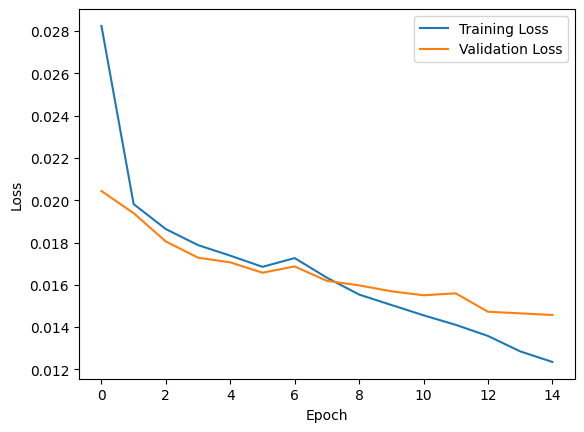

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()